# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [ ]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output

--2021-08-02 02:56:08--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.3’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.06s   

2021-08-02 02:56:09 (3.70 MB/s) - ‘La_noche_estrellada1.jpg.3’ saved [223725/223725]

--2021-08-02 02:56:09--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) [ima

In [ ]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/drive/MyDrive/ADD_VAL/IA/TP FINAL/contenido_1.jpg")
style_reference_image_path = Path("/content/drive/MyDrive/ADD_VAL/IA/TP FINAL/estilo_1.jpg")
result_prefix = Path("/content")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:


1-Seteo variables pesos

**Total_variation_weight:**


Este peso está destinado al término,  total_variational_weight_looss (cuánto va a pesar en la función de costo total). 
La total variational loss, es una función de costo que evalúa la variación entre vecinos cercanos (en términos prácticos la que esa es tomar una fila y restarla a  la fila superior, y lo mismo entre columnas restando la del lateral). Consiguiendo que la imagen final tenga bordes más suaves.
Más abajo se explica cual es el objetivo de esta loss (ver punto 5)
Esta variación se calcula sobre el contenido (no sobre las matrices de gram). En nuestra función de costo total (en la versión original de la notebook entregada),  le estamos indicando que va a tener un peso del 0.1. 
Si este peso es muy alto, la imagen de contenido reduce la diferencia entre píxeles vecinos a tal punto que se pueden perder las divisiones y mezclar los colores (En la sección 5, genere una imagen con este peso en 100 para ver el resultado).
 
**Style_weight:**
Es el peso que le voy a dar en la función de costo total, al término de la loss que trata de minimizar el error en estilo, contra la imagen de ruido blanco. 
Lo que se minimiza es el MSE entre las matrices de gram de los features a la salida de las capas de estilo (en este caso son 5 capas) de la imagen de estilo y la imagen aleatoria creada para ir ajustando.  (se adjunta en el punto 5 las curvas de loss con diferentes pesos, y las imágenes de resultado con diferentes pesos)
*-Content_weight: es el peso que le voy a dar en la función de costo total, al término de la loss que trata de minimizar el error en el contenido, contra la imagen de ruido blanco

**Content_weight:** es el peso que le voy a dar en la función de costo total, al término de la loss que trata de minimizar el error en el contenido (usando MSE) , contra la imagen de ruido blanco

 
**2-Seteo de escala imágenes**
Luego establece el tamaño de las imágenes que se usarán en la función img_to_array. 
Para esto asigna 400 al alto o filas (esto se asigna directamente)
En la línea siguiente se calculan las columnas que tendrá la imagen (o el ancho). Dicho ancho se saca calculando el ratio de la altura asignada 400 sobre la altura original (400/altura original) * ancho_original. Así consigue el nuevo ancho, que mantiene proporción con el alto asignado.

```
#Ejemplo del cambio de dimensiones para ver la transformación
  print(height,width)
  599 775 ->Original
  print (img_nrows,img_ncols)
  400 517 ->Transformada
```



In [ ]:
total_variation_weight = 100
style_weight = 10
content_weight = 1

In [ ]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
print("imagen original",height,width)
img_ncols = int(width * img_nrows / height)
print ("imagen escalada",img_nrows,img_ncols)

imagen original 914 1500
imagen escalada 400 656


# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

**1-np.expand_dims:** Le agrega otra dimensión a la numpy array en la posición indicada. Esto se hace porque la entrada de la red, está dada por (batch Size, alto, ancho, canales). 
En este caso cuando cargo la imagen solo tengo (alto, ancho y los canales). Para poder conseguir el formato de entrada que admite la función preproces_input. Aplicó expand_dim y paso de esto (400, 517, 3) a esto (1, 400, 517, 3)
 

```
#Ejemplo del cambio de shape
print("antes",img.shape)
antes (400, 517, 3)
img = np.expand_dims(img, axis=0)
print("despues",img.shape)
después (1, 400, 517, 3)
```

 

**2-preprocess_input:** La función preprocess_input está destinada a adecuar una imagen al formato que requiere el modelo. 
Algunos modelos utilizan imágenes con valores que van de 0 a 1 (sería la versión normalizada). Otros, de -1 a +1. El que usamos en este momento que es el vgg19  "caffe" (papper página 9 “The model is publicly available and can be explored in the caffe-framework.24”), no está normalizado, sino centrado a cero. 
Entonces  esta función preproce_image hace lo siguiente:

* Recibe el path de la imagen
* Carga la imagen en memoria 
* Convierte la imagen  en un array. 
* Le agrega la dimensión del batch (como se explicó antes) 
* Aca se invoca a preprocess_input, y le pasamos el array obtenido antes, y nos retorna el formato adecuado para entrar en la red. 






In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    print("preprocess_antes",img.shape)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    print("preprocess_despues",img.shape)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

**Objetivo función deprocess_image:**
La VGG trabaja retornando imágenes BGR y centradas a cero.
Para poder ver la imagen o guardarla como jpg necesito pasarla a RGB con valores de píxel de [0,255]. 
El objetivo de esta función es hacer esta conversión de lo que retorna la VGG (RGB centrado a cero) a BGR con valores [0,255]
 
**Como lo hace**
Quitamos el centrado a cero: Para realizar esto sumamos esas medias (que son números fijos 103.939;116.779;123.68)
El origen de estos números  viene del entrenamiento de la red original. La red se entrenó con imágenes, y cuando se calculó la media por canal tomando todos las imágenes arrojó esos valores.
Entonces de las imágenes que resultan a la salida, asumimos que sumándole la media la media por canal,  volverán al rango original (remover el centrado a cero). Para eliminar los casos donde después de sumar la media no quede en el rango correcto [0.255], aplicamos un numpy.clip(0,255)--> los valores por debajo de cero pasan a cero y los que superen 255 quedan en 255.
Luego tengo que revertir el orden de los canales pasar de BGR → RGB, para reasigno la variable x, recorriendo el último eje (el de los canales) de atrás para adelante.


**Ejemplo de numpy clip:**
```
###Ejemplo: Clip
  ejemplo_ff= np.arange(12) 
  print("antes de clip ",ejemplo_ff)
  ejemplo_yy=np.clip(ejemplo_ff, 3, 6) 
  print("despues de clip",ejemplo_yy)
  antes de clip  [ 0  1  2  3  4  5  6  7  8  9 10 11]
  despues de clip [3 3 3 3 4 5 6 6 6 6 6 6]
```



In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
###Ejemplo: Clip
ejemplo_ff= np.arange(12)  
print("antes de clip ",ejemplo_ff)
ejemplo_yy=np.clip(ejemplo_ff, 3, 6)  
print("despues de clip",ejemplo_yy)
  

antes de clip  [ 0  1  2  3  4  5  6  7  8  9 10 11]
despues de clip [3 3 3 3 4 5 6 6 6 6 6 6]


In [ ]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

preprocess_antes (400, 656, 3)
preprocess_despues (1, 400, 656, 3)
preprocess_antes (400, 656, 3)
preprocess_despues (1, 400, 656, 3)


In [ ]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')
model.summary()

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(3, 400, 656, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 656, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 656, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 328, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 328, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 328, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 164, 128)

# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

**1-Matriz de gram:** Nos mide la correlación entre vectores, en este caso la usamos para ver cuán similares son los features maps a la salida de una capa entre sí. 
Si la multiplicación de los vectores da un número alto entonces están  altamente correlacionado, una número bajo poca correlación. 
La idea es que sea cual sea la relación entre features maps, la imagen random busque imitar esa correlación.

**2-Para que se usa:**
La matriz de Gram es una matriz de covarianza empírica. 
Para la transferencia de estilo, calcularemos las matrices gram de los features maps en un conjunto de capas inferiores de la red (las destinadas a estilo).
Para explicar esto podemos tomar una sola capa, suponga que tiene 32 mapas de características. La matriz de gram es la covarianza entre cada uno de los mapas de características. 
Lo que se mide es si, en una posición de píxel en particular, la característica #X tiende a coincidir con la característica #Y. 
Por ejemplo, si en una imagen, siempre que tenga la característica #15 iluminada en un punto en particular, la característica #8 también se ilumina. Vamos a buscar que en la imagen destino el patrón de coincidencia de características coincida.
 
**3-Porque se permuta:** El objetivo es recibir una imagen y retornar la gram matrix de (vectores features por vectores features). Para eso necesitamos hacer una matriz de feature, cuyos lados sean los vectores de features  maps  que tenga a la salida de la capa convolucional. Donde cada vector tendrá una longitud = el alto*el ancho, del feature map. 
Pero primero tenemos que transformar el feature mas que es un Tensor con este formato ((Height, Weight,  Feature = features maps)) → a un tensor que tenga número de feature map  en la primer dimensión y  vector de 1d con el feature map aplanado en la segunda dimensión, quedaría con este shape:  (Feature Map, Height * Weight)
 
**Proceso**
Primero hacemos una permutación de las dimensiones, poniendo como primer eje, el de los features, y dejando luego el alto y el ancho detrás.
Nosotros recibimos en el input un tensor con este shape (H,W,F = features maps) y lo tenemos que convertir a --> (F=Features maps, H*W) 
Entonces al permutar, nos queda atras altura y ancho, y podemos hacer un flaten de estos dos, sin tocar el eje que corresponde a features. O sea el resultante es un vector, de shape (Features, alto*ancho). 
Luego resta hacer la transpuesta para que los mismos vectores que en una matriz son fila en la otra sean columna y se pueda hacer la multiplicación de todos contra todos.
 
 
**Ejemplo:**
Supongamos que tengo 10 mapas de caracteres, de 4x4, entonces para armar la matriz de gam me quedan 10 vectores de 16 de largo. La matriz de gram va a ser de 10 x 10, que son los vectores que tengo.
 
Poniendo un print en la función vemos el resultado, acá se puede ver los distintos shape desde que recibimos X hasta que generamos la gram matrix en la función. 



```
#Resultados del cálculo:
x recibido  gram: (400, 656, 64) → Así recibo los feature maps
X permutado gram: (64, 400, 656) → Permuto y pongo delante los FM
x flatten   gram; Tensor("Reshape:0", shape=(64, 262400), dtype=float32) → genero un vector 2D (Feature maps, altor*ancho)
x flatten transpuesta gram (262400, 64) → Hago transpuesta para poder luego multiplicar vector contra vector
matriz gram resultado  (64, 64) → Matriz resultado
 
Ejemplo simple de cálculo de gram
#Ejemplo:
#Matriz de gram
#Caso A: tengo un vector en la primer fila y el otro ortogonal, o sea hay poca correlación, en la segunda fila la correlacion es maxima
print("caso 1 TV")
aa = np.ones((2,2), dtype=float)
aa[0]=1
aa[1][0]=-1
aa[1][1]=1
print("matriz aa",aa)
bb=np.transpose(aa)
print("trasponemos aa ",bb)
cc=np.dot(aa,bb)
print("resultado producto punto",cc)
#Como vemos los vectores ortogonales dio cero el producto y para los paralelos duplico su modulo
 
caso 1 TV
matriz aa 
[[ 1.  1.]
 [-1.  1.]]
trasponemos aa  
[[ 1. -1.]
 [ 1.  1.]]
resultado producto punto [[2. 0.]
 [0. 2.]]

```

In [ ]:
def gram_matrix(x):
    print("x recibido  gram:",x.shape)
    print("X permutado gram:", K.permute_dimensions(x, (2, 0, 1)).shape)
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    print("x flatten   gram;",features)
    gram = K.dot(features, K.transpose(features))
    print("x flatten transpuesta gram",K.transpose(features).shape)
    print("matriz gram resultado ",gram.shape)
    return gram

In [ ]:
#Ejemplo:
#Matriz de gram
#Caso A: tengo un vector en la primer fila y el otro ortogonal, o sea hay poca correlacion
print("caso 1 TV")
aa = np.ones((2,2), dtype=float)
aa[0]=1
aa[1][0]=-1
aa[1][1]=1
print("matriz aa",aa)
bb=np.transpose(aa)
print("trasponemos aa ",bb)
cc=np.dot(aa,bb)
print("resultado producto punto",cc)
#Como vemos los vectores ortogales dio cero el producto y para los paralelos duplico su modulo

caso 1 TV
matriz aa [[ 1.  1.]
 [-1.  1.]]
trasponemos aa  [[ 1. -1.]
 [ 1.  1.]]
resultado producto punto [[2. 0.]
 [0. 2.]]


# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

**Style_loss:**
Es la función de costo para ajustar el estilo. 
Lo hace calculando el error cuadrático medio entre las matrices de gram de los features maps a la salida de cada una de las capas seleccionadas para estilo, para la imagen con el estilo (desde la cual quiero tomar el estilo pero no el contenido) y la imagen aleatoria (o de ruido blanco como la referencia el paper). 
En este caso son 5 matrices para una imagen fuente del estilo (Fuente) y 5 para la imagen destino (Destino), entonces el cálculo será: MSE entre ([Gram(Fuente1)-Gram(Destino1)]+....+[Gram(Fuente5)-Gram(Destino5)]). 
Las capas que se utilizan, son las capas menos profundas de la red. 

**Aca se marcan cuales son:**

```
block1_conv1 (3, 3, 3, 64) -->Style
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128) -->Style
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256) -->Style
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block3_conv4 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512) -->Style
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block4_conv4 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)-->Style
block5_conv2 (3, 3, 512, 512)-->Contenido
block5_conv3 (3, 3, 512, 512)
block5_conv4 (3, 3, 512, 512)
```





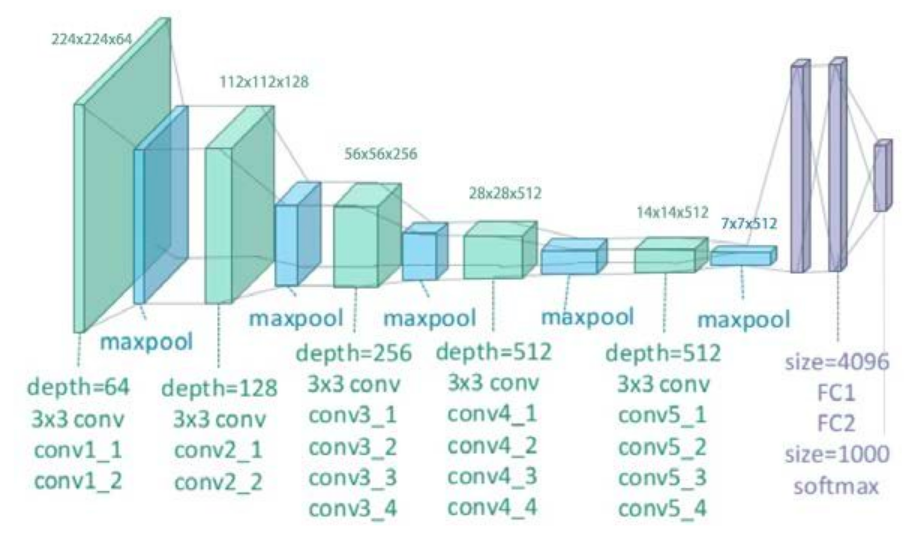

**content_loss:** 
Aca la función de costo es más simple, es un error cuadrático medio de un  feature map contra otro feature map (sin realizar cálculos con el contenido del feature map). Entonces tomó el feature map a la salida de la capa seleccionada para contenido de: En primer lugar la imagen aleatoria (la cual es input de la red, y es este input el que se entrena, acá entrenamos o ajustamos la imagen no los pesos de la red,  para que su contenido en la próxima pasada reduzca el error),  en segundo lugar la imagen fuente de la cual voy a copiar el contenido (pero no el estilo). Con estos dos features maps, resto uno al otro y calculo el error cuadrático medio. 
Las capas que se usan acá son las más cercanas a la salida. En este ejemplo usamos la “block5_conv2”

**Total variational weight:** 
Esto es un agregado que no está en el paper. Lo que calcula es la variación dentro de la misma imagen entre, en primer lugar las filas comparando la filas desde la posición 0 a la posición filas totales - 1, con las que van de la posición 1 hasta el final (filas totales) esto hace que compare cada fila con la que está justo encima obteniendo la variación entre las filas cercanas. 
Luego hace lo mismo con el ancho (que serían las columnas). 
Con lo cual termina obteniendo dos matrices con la diferencia entre vecinos cercanos. Luego las suma y les aplica una exponenciación, y suma todos los resultados y así se consigue un escalar que representa las diferencias absolutas para los valores de píxeles vecinos en la imagen de entrada. 
Esto estaría, de alguna forma, midiendo cuánto ruido hay en las imágenes o cuán fuerte son las transiciones. 
Si el número obtenido es es grande hay mucha variación, si es cero son vecinos idénticos.
Al agregar la variación total a la función de costo del entrenamiento la imagen resultante se ve mucho más suave. 
(Se realizaron  pruebas variando el peso de esta loss y se adjuntan en el repo, con el sufijo tv_xx, donde xx es el peso asignado)

*A continuación un código de prueba donde se verifica el cálculo explicado con matrices pequeñas para su comprensión, mostrando el caso de un matriz donde los vecinos varían mucho (loss grande)  y otra donde no hay variación (loss pequeña):

```
##Ejemplo:
##Se realiza un ejemplo simple de lo que hace la Total Variational loss
#Caso A: la diferencia entre vecinos es grande entre filas
print("caso 1 TV")
aa = np.ones((3,3), dtype=float)
aa[1]=2
aa[2]=5
print("Matriz A vecinos muy distintos",aa)
tt=aa[:2, :] - aa[1:, :]
jj=aa[:,:2] - aa[:,1:]
print("Diferencia filas",tt,"Diferencia Columnas",jj)
ss=np.square(tt)
zz=np.square(jj)
totalxx=K.sum(K.pow(ss, 1.25))
print("total variation A:",K.eval(totalxx))
 
print("caso 2 TV")
#Caso B: la diferencia entre vecinos es pequña entre filas
aa = np.ones((3,3), dtype=float)
aa[1]=1.1
aa[2]=1.2
print("Matriz b vecinos parecidos",aa)
tt=aa[:2, :] - aa[1:, :]
jj=aa[:,:2] - aa[:,1:]
print("Diferencia filas",tt,"Diferencia Columnas",jj)
ss=np.square(tt)
zz=np.square(jj)
totalxx=K.sum(K.pow(ss, 1.25))
print("total variation B:",K.eval(totalxx))
##Fin Ejemplo
caso 1 TV
Matriz A vecinos muy distintos [[1. 1. 1.]
 [2. 2. 2.]
 [5. 5. 5.]]
Diferencia filas [[-1. -1. -1.]
 [-3. -3. -3.]] Diferencia Columnas [[0. 0.]
 [0. 0.]
 [0. 0.]]
total variation A: 49.76537180435969
caso 2 TV
Matriz b vecinos parecidos [[1.  1.  1. ]
 [1.1 1.1 1.1]
 [1.2 1.2 1.2]]
Diferencia filas [[-0.1 -0.1 -0.1]
 [-0.1 -0.1 -0.1]] Diferencia Columnas [[0. 0.]
 [0. 0.]
 [0. 0.]]
total variation B: 0.018973665961010265
```

*A continuación los gráficos de la loss con diferentes entrenamientos donde se asignaron distintos pesos, para entender como la magnitud de cada número es diferentes, cuan rápido converge cada una al mínimo, y de esta forma asignar pesos en ratios que favorezcan la convergencia de la loss total. 
Según lo mostrado en los gráficos, para mi la distribución de pesos del caso C, es la mejor, porque iguala la magnitud de los escalares de cada loss, todos quedan cerca de 1xe10 aprox. En el caso D vemos como bajando la diferencia entre vecinos (Total variational loss con un alto peso), se terminan por mezclar los bordes.  
 



**IMAGEN CONTENIDO:**
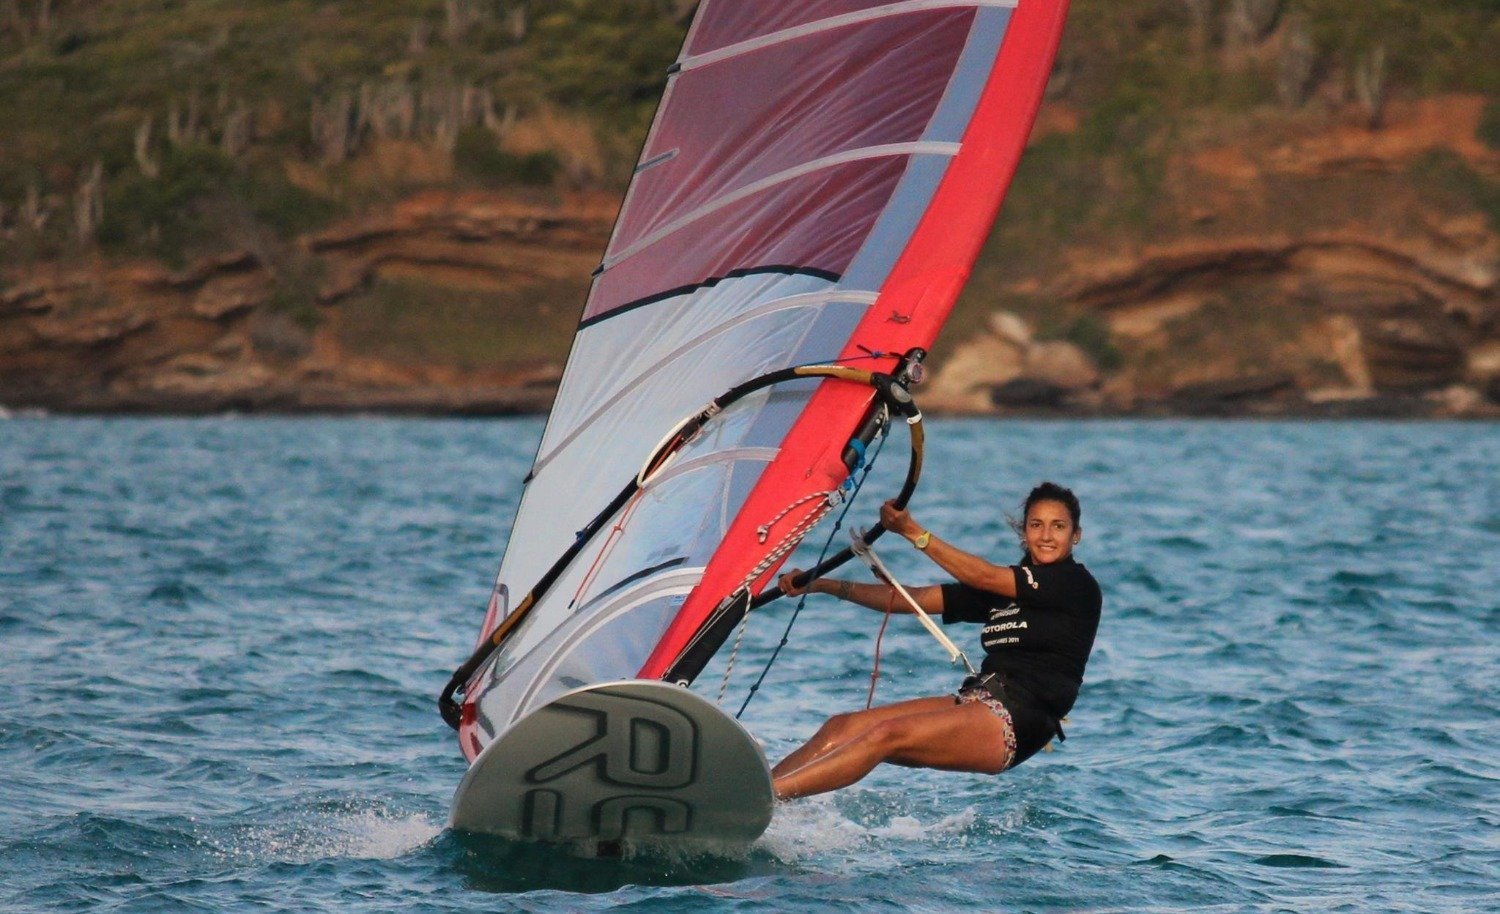

**IMAGEN ESTILO**
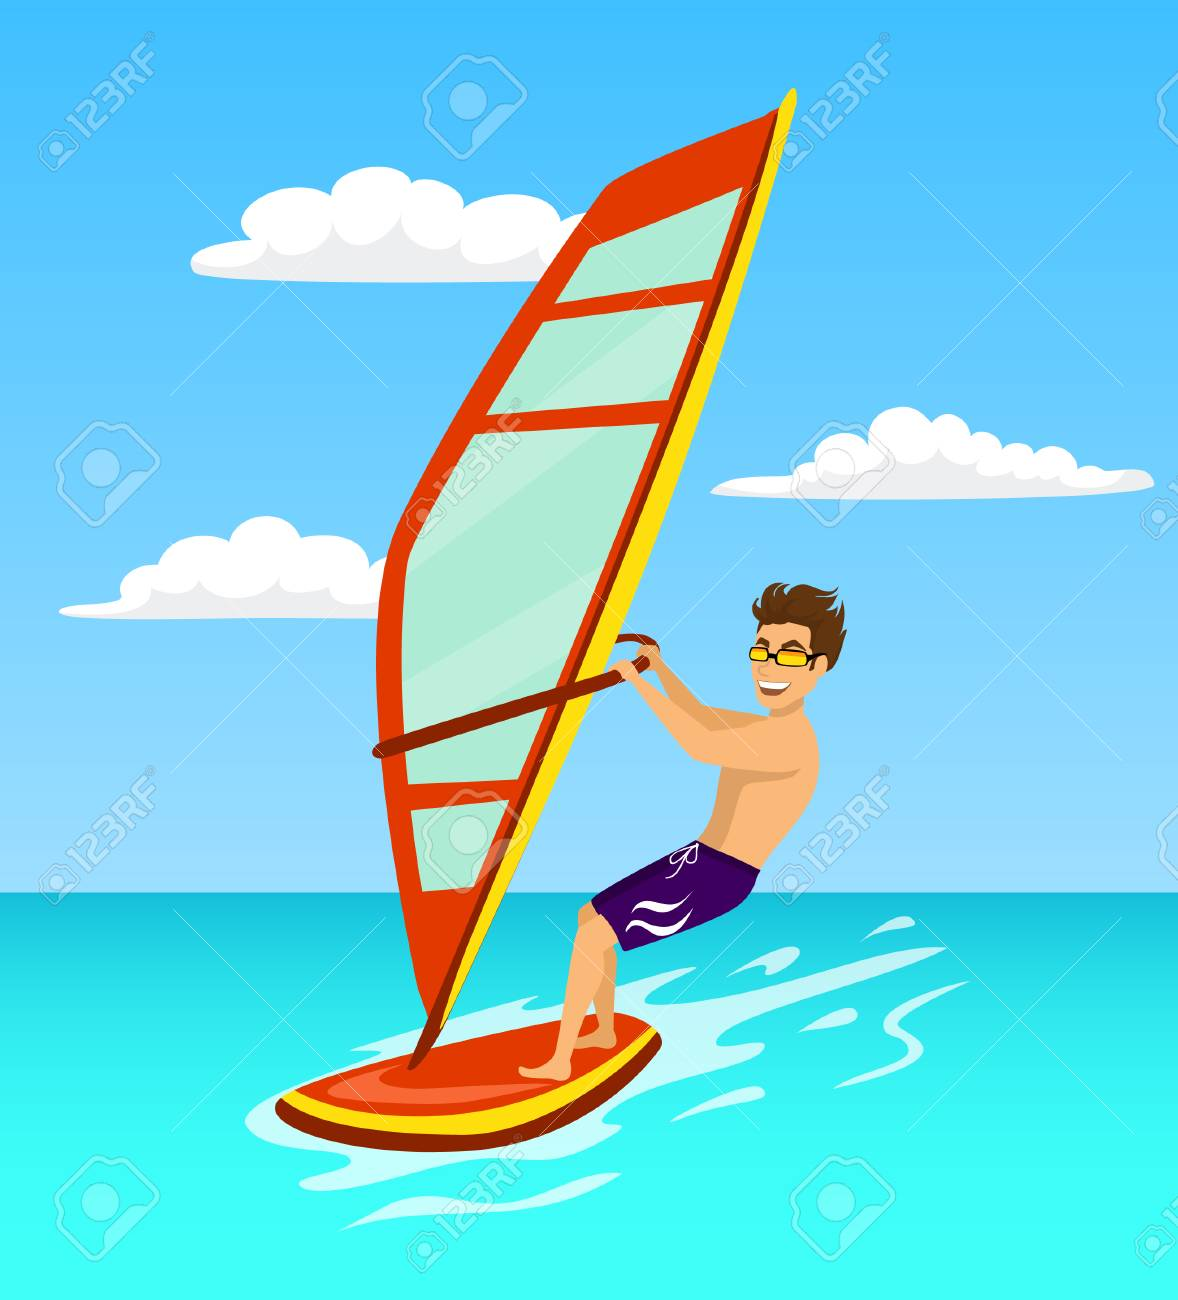

**A-PESOS (Style=10, Content=1, Total Varitatinal=0)**

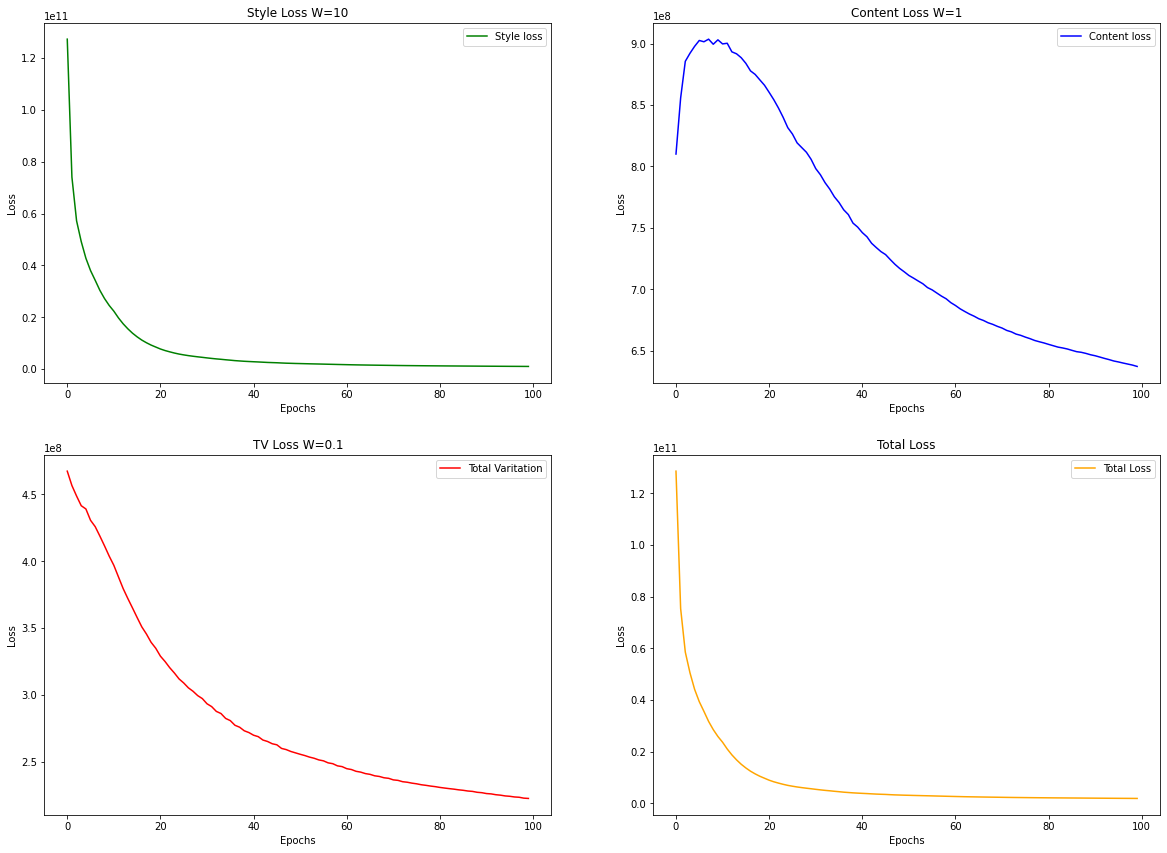

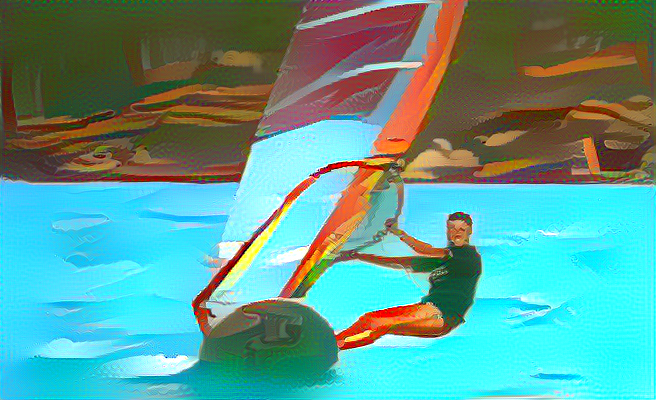

**Observación:** Con la total variational en cero se puede ver en el contorno del cuerpo de la windsurfista que la transición es bien marcada con el agua. El estilo al estar con un peso de 10 ganó preponderancia y borró algunos detalles de contenido como la cara de la persona.


**B-PESOS (Style=10, Content=1, Total Varitatinal=0.1)**

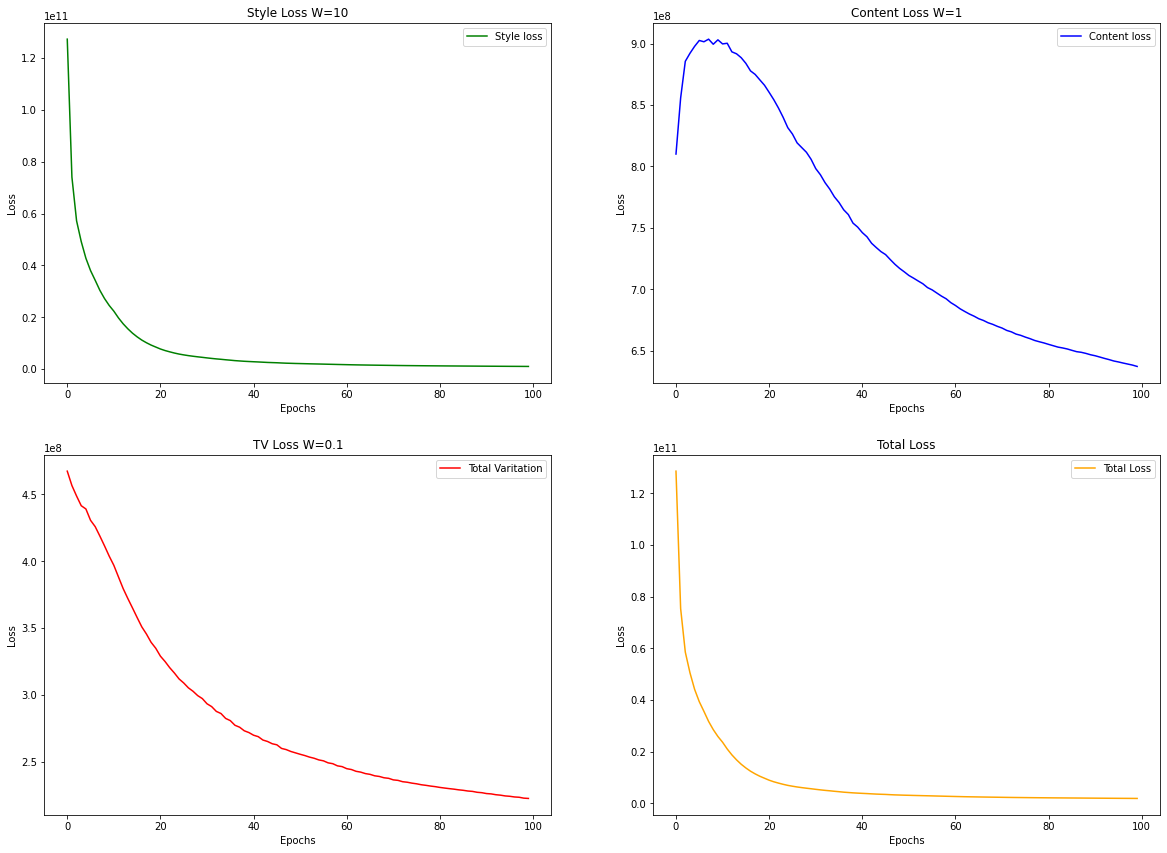

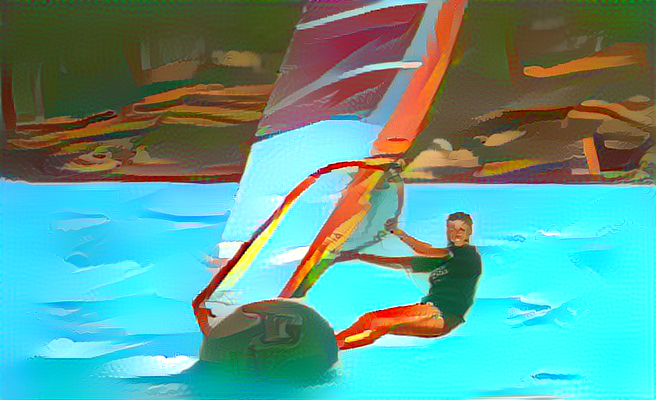

**Observación:** Con la total variational en 0.1, no difiere mucho del caso A

**C-PESOS (Style=1, Content=10, Total Varitatinal=0.1)-->Mejor**

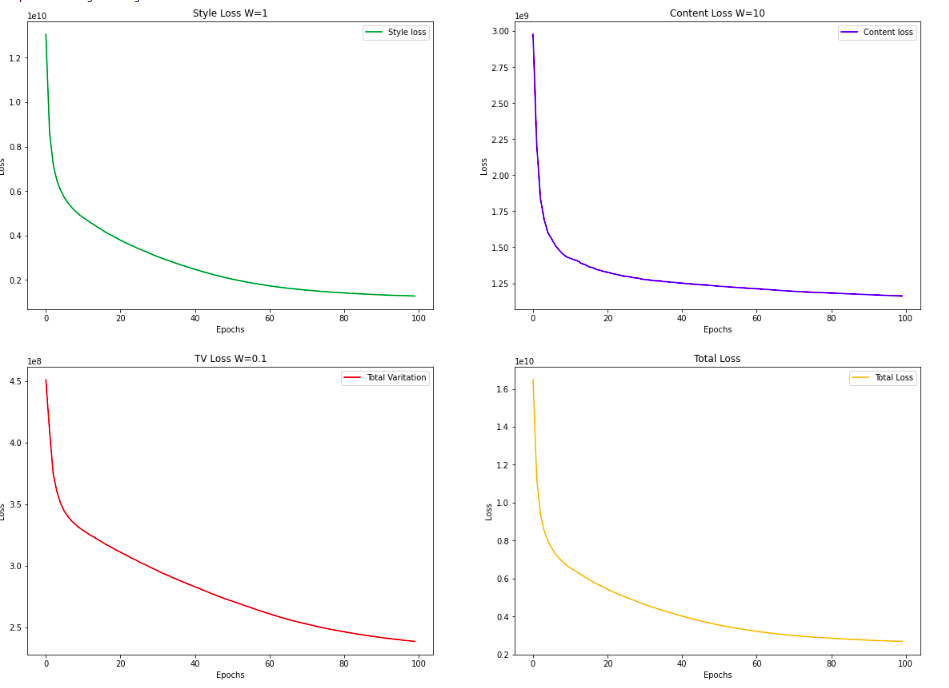

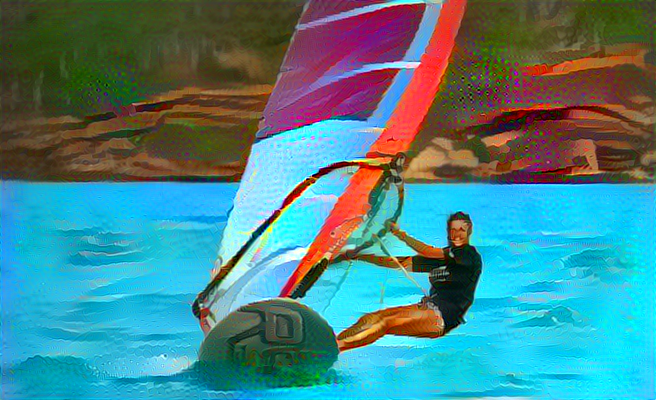

**Observación:** Con un peso de 10 para el contenido y 1 para el estilo, obtenemos la mejor versión, tenemos los colores del estilo, pero se puede distinguir mejor la cara, las rodillas y la punta de la tabla.

**D-PESOS (Style=10, Content=1, Total Varitatinal=100)**

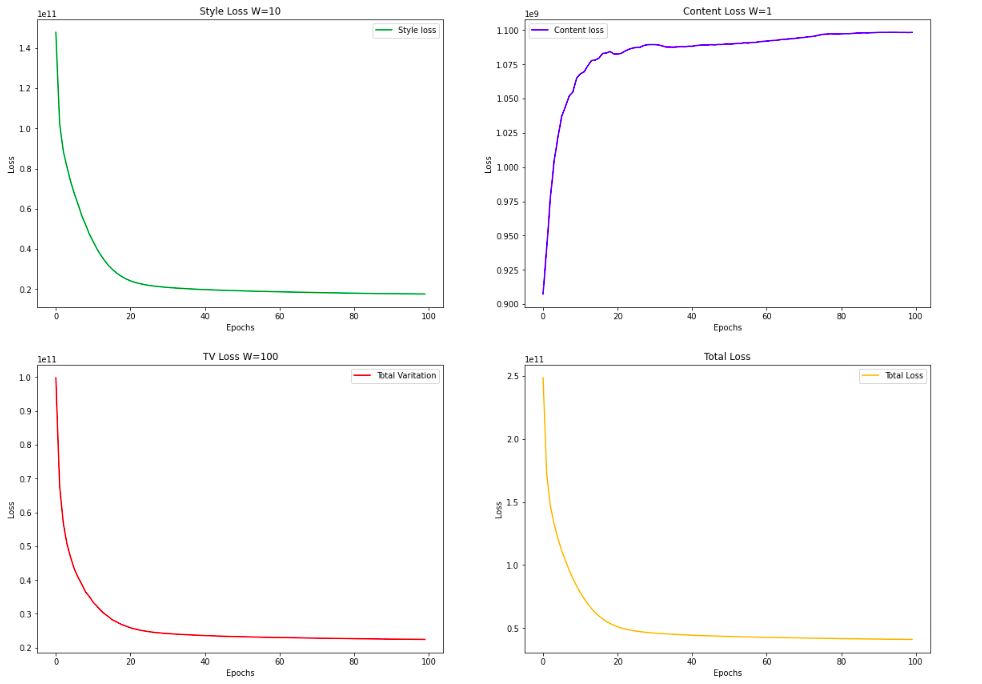

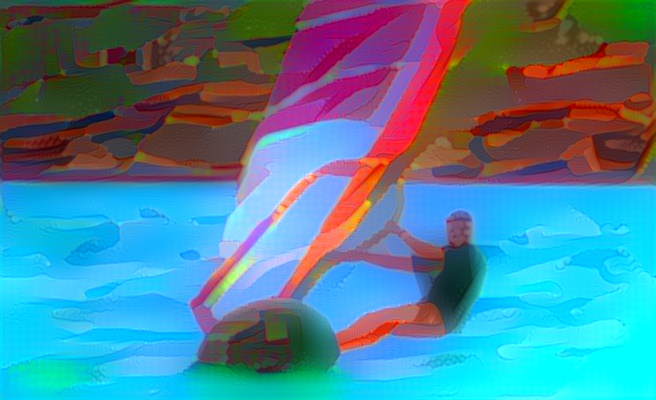

**Observación:** Con la total variational en 100 al eliminar la variación entre vecinos cercanos, vemos como por ejemplo en el borde que limita la espalda con el agua, se crea un borde fantasma donde se mezclan colores y se pierde nitidez. Y esto se puede comprobar en la loss del contenido que al tener poco peso, si bien la loss total mejora con las iteraciones, las loss de contenido por si sola empeora.


**E-PESOS (Style=1, Content=10, Total Varitatinal=100)**

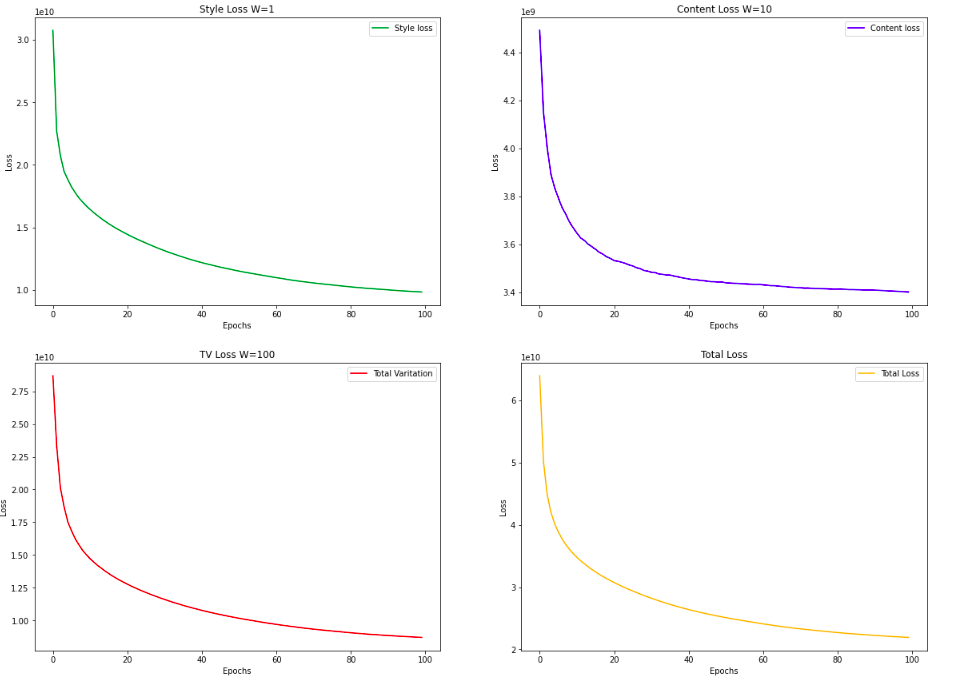

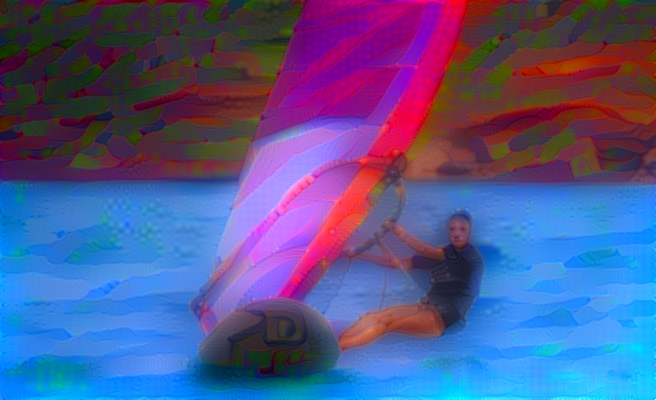

**Observación:** Con la total variational en 100 se pierde nitidez como antes, pero acá, con el peso invertido entre estilo y contenido, los bordes se mantienen un poco más nítidos (por el peso mayor del contenido) y los colores se mezclan. 

In [ ]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [ ]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [ ]:
##Ejemplo: 
##Se realiza un ejemplo simple de lo que hace la Total Variational loss

#Caso A: la diferencia entre vecinos es grande entre filas 
print("caso 1 TV")
aa = np.ones((3,3), dtype=float)
aa[1]=2
aa[2]=5
print("Matriz A vecinos muy distintos",aa)
tt=aa[:2, :] - aa[1:, :]
jj=aa[:,:2] - aa[:,1:]
print("Diferencia filas",tt,"Diferencia Columnas",jj)
ss=np.square(tt)
zz=np.square(jj)
totalxx=K.sum(K.pow(ss, 1.25))
print("total variation A:",K.eval(totalxx))

print("caso 2 TV")
#Caso B: la diferencia entre vecinos es pequña entre filas 
aa = np.ones((3,3), dtype=float)
aa[1]=1.1
aa[2]=1.2
print("Matriz b vecinos parecidos",aa)
tt=aa[:2, :] - aa[1:, :]
jj=aa[:,:2] - aa[:,1:]
print("Diferencia filas",tt,"Diferencia Columnas",jj)
ss=np.square(tt)
zz=np.square(jj)
totalxx=K.sum(K.pow(ss, 1.25))
print("total variation B:",K.eval(totalxx))
##Fin Ejemplo


caso 1 TV
Matriz A vecinos muy distintos [[1. 1. 1.]
 [2. 2. 2.]
 [5. 5. 5.]]
Diferencia filas [[-1. -1. -1.]
 [-3. -3. -3.]] Diferencia Columnas [[0. 0.]
 [0. 0.]
 [0. 0.]]
total variation A: 49.76537180435969
caso 2 TV
Matriz b vecinos parecidos [[1.  1.  1. ]
 [1.1 1.1 1.1]
 [1.2 1.2 1.2]]
Diferencia filas [[-0.1 -0.1 -0.1]
 [-0.1 -0.1 -0.1]] Diferencia Columnas [[0. 0.]
 [0. 0.]
 [0. 0.]]
total variation B: 0.018973665961010265


In [ ]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

graph_loss_weight= content_weight * content_loss(base_image_features,
                                            combination_features)
graph_loss_style=0
graph_loss_tv=0

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
    graph_loss_style = graph_loss_style + (style_weight / len(feature_layers)) * sl
    
loss = loss + total_variation_weight * total_variation_loss(combination_image)
graph_loss_tv = total_variation_weight * total_variation_loss(combination_image)

x recibido  gram: (400, 656, 64)
X permutado gram: (64, 400, 656)
x flatten   gram; Tensor("Reshape:0", shape=(64, 262400), dtype=float32)
x flatten transpuesta gram (262400, 64)
matriz gram resultado  (64, 64)
x recibido  gram: (400, 656, 64)
X permutado gram: (64, 400, 656)
x flatten   gram; Tensor("Reshape_1:0", shape=(64, 262400), dtype=float32)
x flatten transpuesta gram (262400, 64)
matriz gram resultado  (64, 64)
x recibido  gram: (200, 328, 128)
X permutado gram: (128, 200, 328)
x flatten   gram; Tensor("Reshape_2:0", shape=(128, 65600), dtype=float32)
x flatten transpuesta gram (65600, 128)
matriz gram resultado  (128, 128)
x recibido  gram: (200, 328, 128)
X permutado gram: (128, 200, 328)
x flatten   gram; Tensor("Reshape_3:0", shape=(128, 65600), dtype=float32)
x flatten transpuesta gram (65600, 128)
matriz gram resultado  (128, 128)
x recibido  gram: (100, 164, 256)
X permutado gram: (256, 100, 164)
x flatten   gram; Tensor("Reshape_4:0", shape=(256, 16400), dtype=float32)

In [ ]:
grads = K.gradients(loss, combination_image)


outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)



In [ ]:
#Calculo losses independientes
outputs_c = [graph_loss_weight]
outputs_s = [graph_loss_style]
outputs_tv = [graph_loss_tv]

f_outputs_c = K.function([combination_image], outputs_c)
f_outputs_s = K.function([combination_image], outputs_s)
f_outputs_tv = K.function([combination_image], outputs_tv)

def loss_fer(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    loss_value_c = f_outputs_c([x])[0]
    loss_value_s = f_outputs_s([x])[0]
    loss_value_tv = f_outputs_tv([x])[0]
    return loss_value_c, loss_value_s,loss_value_tv


# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

Antes de explicar las funciones requeridas, es necesario entender el objetivo que perseguimos con esta implementación.
Lo que buscamos es actualizar iterativamente nuestra imagen de salida de modo que minimice nuestra función de costo. A diferencia de otras implementaciones, acá no actualizamos los pesos asociados con nuestra red, sino que entrenamos nuestra imagen de entrada.
 
**1- La funcion fmin_l_bfgs_b:**
Lo que hace esta función es,  buscar un mínimo para la función que pasamos por parámetro usando el algoritmo L-BFGS-B. (Búsqueda de mínimos o de raíces, lo que hace por ejemplo regula falsi) 
Le estamos pasando: la funcion que quiero minimizar (función de la cual quiero encontrar un  input X que me de un mínimo 
Le pasamos entonces, el input actual (el X) donde estoy parado (esperamos que luego de aplicar la función retorne un nuevo input, que minimice el resultado de la loss) 


In [ ]:
##EJEMPLO:
##Como funciona la busqueda de minimos de fmin_l_bfgs
#Aca tenemos un ejemplo corto de como minimiza la funcion F(x)=x^2, aca sabemos que el minimo es cero. Tiene que buscar el x que mas se aproxime a este valor
#Le podria pasar args los args son constantes no los optimiza, pero me permiten por ejemplo: 
#si uso una recta tener diferentes pendientes en cada llamada, o si buscmo minimizar error cuadratico, le puedo pasar el par de Y_TRUE, para que vaya probando la resta
#'x' y 'x0' son los parametros que estoy optimizando - el resto es todo argumento

#<Caso A: X²>:
def func(x, *args):
    print("x ", x)
    return (x**2) + 1

initial_values = np.array([10])
print("initial_values ", initial_values)

tt, min_val, info  =fmin_l_bfgs_b(func, x0=initial_values, args=(0,0), approx_grad=True)
print("x:",tt, "minval: ", min_val, "info :",info)

y_true =(-7.10542736e-15)**2 + 1
print("comprobacion del resultado",y_true)
#</Caso A: X²>

#<Caso B: MSE>
x_true = np.arange(0,10,0.1)
print("valores x ",x_true)
m_true = 2
b_true = 1.0
y_true = m_true*x_true + b_true
print("valor de y_true",y_true)

def func(params, *args):
    #print("params ", params)
    #print("args ", args)
    x = args[0]
    y = args[1]
    m, b = params
    y_model = m*x+b
    error = y-y_model
    return sum(error**2)

initial_values = np.array([0, 0])
print("initial_values ", initial_values)
tt, min_val, info  =fmin_l_bfgs_b(func, x0=initial_values, args=(x_true,y_true), approx_grad=True)
print("x:",tt, "minval: ", min_val, "info :",info)

#Comprobacion del resultado
y_calculado = tt[0]*x_true + tt[1]
error = y_true-y_calculado
print("comprobacion del resultado",sum(error**2))
#</Caso B: MSE>


#Fin test de la funcion

initial_values  [10]
x  [10.]
x  [10.00000001]
x  [9.]
x  [9.00000001]
x  [-7.10542736e-15]
x  [9.99999289e-09]
x: [-7.10542736e-15] minval:  [1.] info : {'grad': array([0.]), 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 6, 'nit': 2, 'warnflag': 0}
comprobacion del resultado 1.0
valores x  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1
 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9
 9.  9.1 9.2 9.3 9.4 9.5 9.6 9.7 9.8 9.9]
valor de y_true [ 1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6
  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4  5.6  5.8  6.   6.2  6.4
  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2
  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11. 

**2-Diferencias:**


*   **Total Variational**: La primer diferencia con el paper es el agregado de la total variational loss a la loss total, en el paper no se implementa esta función, que como explique anteriormente sirve para suavizar las transiciones. 
*   **Average pooling**: El paper propone cambiar las capas de max pooling, por average pooling "For image synthesis we found that replacing the
max-pooling operation by average pooling improves the gradient flow and one obtains slightly more appealing results". Segun lo que menciona, cuando habla de un mejoramiento del gradient flow, podemos esperar que haciendo esto, la convergencia sea mas rapida o inclusive de minimos mas pequeños.
*   **Capas**: El uso de las capas puede variar siempre que se mantenga el uso de las mas tempranas para estilo y las finales para contenido. Por ejemplo para la figura dos del paper usa las mismas capas de estilo que esta implementacion para cambia la de contenido, esta implementacion usa la block5_conv_2  (Fig 2 we matched the **content representation on layer ‘conv42’** and thestyle representations on layers ‘conv11’, ‘conv21’, ‘conv31’, ‘conv41’ and ‘conv51’ )




 




**3-Alternativa:**
Podemos usar diferentes alternativas para minimizar la función de costo en vez de usar “fmin_l_bfgs_b”.
Por ejemplo el “AdamOptimizer”. Se adjunta una notebook donde se utilizó este optimizador para buscar el mínimo.
Básicamente tendría que declarar como se ve a continuación este optimizador, y aplicarlo a la imagen

```
opt = tf.train.AdamOptimizer(learning_rate=10.0)
grads, all_loss = eval_loss_and_grads(x)
opt.apply_gradients([(grads, init_image)])
Y de esta manera obtener init_image minimizada
```



In [ ]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [ ]:
#Agregado fer alternativa
# Create our optimizer
#opt = tf.optimizers.Adam(learning_rate=10.0)


In [ ]:
evaluator = Evaluator()

loss_train_style=np.array([])
loss_train_content=np.array([])
loss_train_tv=np.array([])
loss_train_total=np.array([])



#test = np.append(test, i)


# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    
    #original
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)

    #<Grafico>
    train_loss,train_grads = eval_loss_and_grads(x)
    loss_train_total=np.append(loss_train_total, train_loss)
    print("traing ", train_loss)
    a,b,c = loss_fer(x)
    print(a,b,c)
    print("sumado ", (a+b+c))
    loss_train_style  =np.append(loss_train_style  ,b)
    loss_train_content=np.append(loss_train_content,a)
    loss_train_tv     =np.append(loss_train_tv     ,c)
    #</Grafico>

    

    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))



preprocess_antes (400, 656, 3)
preprocess_despues (1, 400, 656, 3)
Start of iteration 0
traing  248833020000.0
906867300.0 147863670000.0 100062480000.0
sumado  248833020000.0
Current loss value: 248833020000.0
Image saved as /content/output_at_iteration_0.png
Iteration 0 completed in 15s


initial_values  [10]
x  [10.]
x  [10.00000001]
x  [9.]
x  [9.00000001]
x  [-7.10542736e-15]
x  [9.99999289e-09]
x: [-7.10542736e-15] minval:  [1.] info : {'grad': array([0.]), 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 6, 'nit': 2, 'warnflag': 0}
comprobacion del resultado 1.0
valores x  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1
 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9
 9.  9.1 9.2 9.3 9.4 9.5 9.6 9.7 9.8 9.9]
valor de y_true [ 1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6
  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4  5.6  5.8  6.   6.2  6.4
  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2
  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11. 

#GRAFICOS DE LOSS


[1.47863667e+11] [9.06867328e+08] [1.00062478e+11]


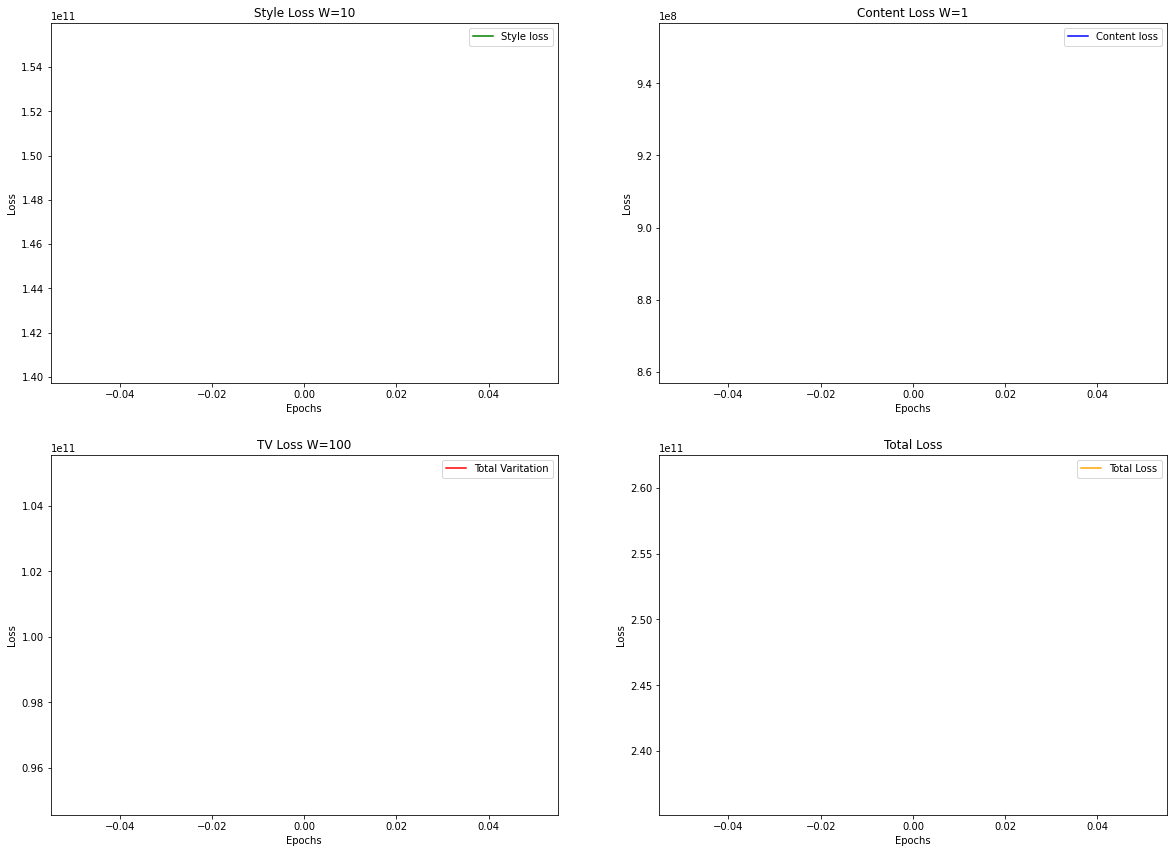

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2,figsize=(20,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)

print(loss_train_style,loss_train_content,loss_train_tv)
epochs = range(0,iterations)
#plt.plot(epochs, loss_train_style, 'g', label='Style loss')
axs[0,0].plot(epochs, loss_train_style, 'g', label='Style loss')
axs[0,0].set_title('Style Loss W=10')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].legend()


#plt.plot(epochs, loss_train_content, 'b', label='Content loss')
axs[0,1].plot(epochs, loss_train_content, 'b', label='Content loss')
axs[0,1].set_title('Content Loss W=1')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Loss')
axs[0,1].legend()


#plt.plot(epochs, loss_train_tv, 'r', label='Total Varitation')
axs[1,0].plot(epochs, loss_train_tv, 'r', label='Total Varitation')
axs[1,0].set_title('TV Loss W=100')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Loss')
axs[1,0].legend()


#plt.plot(epochs, loss_train_total, 'r', label='Total Loss')
axs[1,1].plot(epochs, loss_train_total, 'orange', label='Total Loss')
axs[1,1].set_title('Total Loss')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Loss')
axs[1,1].legend()




# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:
Se explicó en el punto sobre la loss (Ver punto 5)

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:
